In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 23 07:36:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
reviews = pd.read_json("drive/MyDrive/news_category_trainingdata.json")


In [ ]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

reviews[reviews['category'].str.contains("HEALTHY LIVING")]

reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)

reviews['healthy'].describe()

count    200853.000000
mean          0.033328
std           0.179492
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: healthy, dtype: float64

In [ ]:
# We have replaced the sample count with a smaller number in order to expedite
# the completion of the lab. For your final project, you will want to use the
# full balanced document set which is determined by this commented line:
#sample_amount =  len(reviews[reviews["healthy"] == 1]) # the total number of healthy living articles

sample_amount = len(reviews[reviews["healthy"] == 1])

healthy = reviews[reviews['healthy'] == 1].sample(n=sample_amount)
not_healthy = reviews[reviews['healthy'] == 0].sample(n=sample_amount)

review_sample = pd.concat([healthy,not_healthy])

review_sample.describe()

,healthy
count,13388.000000
mean,0.500000
std,0.500019
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']


train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy"],
    val_df=None,
    max_features=20000,
    maxlen=128,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_healthy', 'healthy']
        not_healthy  healthy
84098           1.0      0.0
107303          0.0      1.0
153190          1.0      0.0
44928           0.0      1.0
180047          1.0      0.0
['not_healthy', 'healthy']
        not_healthy  healthy
92951           0.0      1.0
15823           0.0      1.0
39325           1.0      0.0
105531          0.0      1.0
99618           0.0      1.0


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 71


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 28
	95percentile : 58
	99percentile : 69


In [ ]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

In [ ]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
753/753 [==============================] - 175s 210ms/step - loss: 0.6525 - accuracy: 0.6374
Epoch 2/6
753/753 [==============================] - 166s 221ms/step - loss: 0.3795 - accuracy: 0.8429
Epoch 3/6
753/753 [==============================] - 166s 220ms/step - loss: 0.4603 - accuracy: 0.7649
Epoch 4/6
753/753 [==============================] - 166s 220ms/step - loss: 0.6988 - accuracy: 0.5062
Epoch 5/6
753/753 [==============================] - 160s 213ms/step - loss: 0.7024 - accuracy: 0.4995
Epoch 6/6
753/753 [==============================] - 49s 65ms/step - loss: 40.7840 - accuracy: 0.4860


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


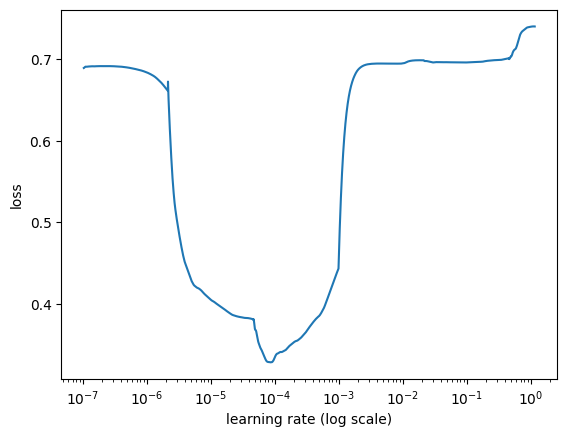

In [ ]:
learner.lr_plot()

In [ ]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
754/754 [==============================] - 186s 231ms/step - loss: 0.3902 - accuracy: 0.8344 - val_loss: 0.3118 - val_accuracy: 0.8723
Epoch 2/10
754/754 [==============================] - 171s 226ms/step - loss: 0.2359 - accuracy: 0.9098 - val_loss: 0.3345 - val_accuracy: 0.8745
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

42/42 [==============================] - 7s 143ms/step
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       692
           1       0.83      0.93      0.88       647

    accuracy                           0.87      1339
   macro avg       0.88      0.87      0.87      1339
weighted avg       0.88      0.87      0.87      1339



In [ ]:
predictor.save("drive/MyDrive/MSDSTextClassification_Lab2.healthy_living")